In [1]:
import sys
import os
import math
from builtins import int

import numpy as np
from torch.utils.data import Dataset
import cv2
import torch

src_dir = os.path.dirname(os.path.realpath('kitti_dataset'))
while not src_dir.endswith("sfa"):
    src_dir = os.path.dirname(src_dir)
if src_dir not in sys.path:
    sys.path.append(src_dir)

from data_process.kitti_data_utils import gen_hm_radius, compute_radius, Calibration, get_filtered_lidar
from data_process.kitti_bev_utils import makeBEVMap, drawRotatedBox, get_corners
from data_process import transformation
import config.kitti_config as cnf
from data_process.kitti_dataset import KittiDataset

In [2]:
from easydict import EasyDict as edict
from data_process.transformation import OneOf, Random_Scaling, Random_Rotation, lidar_to_camera_box
from utils.visualization_utils import merge_rgb_to_bev, show_rgb_image_with_boxes


In [6]:
import matplotlib.pyplot as plt

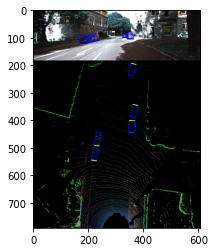

In [8]:
configs = edict()
configs.distributed = False  # For testing
configs.pin_memory = False
configs.num_samples = None
configs.input_size = (608, 608)
configs.hm_size = (152, 152)
configs.max_objects = 50
configs.num_classes = 3
configs.output_width = 608

configs.dataset_dir = os.path.join('../', 'dataset', 'kitti')
# lidar_aug = OneOf([
#     Random_Rotation(limit_angle=np.pi / 4, p=1.),
#     Random_Scaling(scaling_range=(0.95, 1.05), p=1.),
# ], p=1.)
lidar_aug = None

dataset = KittiDataset(configs, mode='val', lidar_aug=lidar_aug, hflip_prob=0., num_samples=configs.num_samples)

# print('\n\nPress n to see the next sample >>> Press Esc to quit...')
for idx in range(len(dataset)):
    bev_map, labels, img_rgb, img_path = dataset.draw_img_with_label(idx)
    calib = Calibration(img_path.replace(".png", ".txt").replace("image_2", "calib"))
    bev_map = (bev_map.transpose(1, 2, 0) * 255).astype(np.uint8)
    bev_map = cv2.resize(bev_map, (cnf.BEV_HEIGHT, cnf.BEV_WIDTH))

    for box_idx, (cls_id, x, y, z, h, w, l, yaw) in enumerate(labels):
        # Draw rotated box
        yaw = -yaw
        y1 = int((x - cnf.boundary['minX']) / cnf.DISCRETIZATION)
        x1 = int((y - cnf.boundary['minY']) / cnf.DISCRETIZATION)
        w1 = int(w / cnf.DISCRETIZATION)
        l1 = int(l / cnf.DISCRETIZATION)

        drawRotatedBox(bev_map, x1, y1, w1, l1, yaw, cnf.colors[int(cls_id)])
    # Rotate the bev_map
    bev_map = cv2.rotate(bev_map, cv2.ROTATE_180)

    labels[:, 1:] = lidar_to_camera_box(labels[:, 1:], calib.V2C, calib.R0, calib.P2)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    img_rgb = show_rgb_image_with_boxes(img_rgb, labels, calib)

    out_img = merge_rgb_to_bev(img_rgb, bev_map, output_width=configs.output_width)
#     cv2.imshow('bev_map', out_img)
    plt.imshow(out_img)
    break
#     if cv2.waitKey(0) & 0xff == 27:
#         break